In [1]:
# open libraries
import matplotlib.pyplot as plt
import glob

from skimage.feature import *
from skimage.measure import *
from skimage.segmentation import *
from scipy import stats
from sklearn.metrics import classification_report,confusion_matrix


# import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img


from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


# plotting
import seaborn as sns

/Users/ericasoo/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Preprocessing

In [2]:
# set up paths

train_dir = 'chest_xray_small_dataset/chest_xray/train/'
test_dir = 'chest_xray_small_dataset/chest_xray/test/'

train_normal_path = 'chest_xray_small_dataset/chest_xray/train/NORMAL/'
train_pneumonia_path = 'chest_xray_small_dataset/chest_xray/train/PNEUMONIA/'
test_normal_path = 'chest_xray_small_dataset/chest_xray/test/NORMAL/'
test_pneumonia_path = 'chest_xray_small_dataset/chest_xray/test/PNEUMONIA/'

test_normal_titles = []
for fname in glob.glob(test_normal_path+'*.jpeg', recursive=False):
    test_normal_titles.append(fname)
    
test_pneumonia_titles = []
for fname in glob.glob(test_pneumonia_path+'*.jpeg', recursive=False):
    test_pneumonia_titles.append(fname)

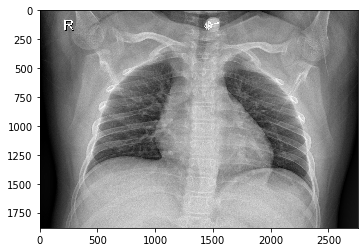

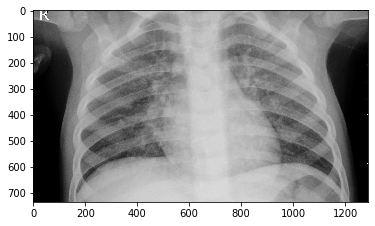

In [3]:
# check images are being accessed
img_normal = load_img(test_normal_titles[0])
plt.imshow(img_normal)
plt.show()
img_normal = load_img(test_pneumonia_titles[0])
plt.imshow(img_normal)
plt.show()

In [13]:
SEED=1
BATCH_SIZE=32
RESCALED_IMAGE_SIZE=(224,224) # images will be all resized to this - they will have 3 channels
LEARNING_RATE = 1e-3 # Some common values are 1e-3 (0.001) or 1e-5 (0.00001)
NUM_EPOCHS = 10 # how many epochs to train for (each epoch visits the training data once) [5 might be good for a trial run]

In [14]:
# note we specify a SEED to make sure train and val splits don't overlap
# this will do 80% train, 20% val
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=RESCALED_IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=RESCALED_IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

# you can optimise data loading with prefetching 
PREFETCH_SIZE = 10
train_ds = train_ds.prefetch(buffer_size=PREFETCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=PREFETCH_SIZE)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=SEED,
    image_size=RESCALED_IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)


Found 1327 files belonging to 2 classes.
Using 1062 files for training.
Found 1327 files belonging to 2 classes.
Using 265 files for validation.
Found 624 files belonging to 2 classes.


# 2. Model

## RESNET

In [16]:
# create the base pre-trained model
resnet_base_model = ResNet50(weights='imagenet', include_top=False)

In [45]:
# fine tuning
# a global spatial average pooling layer to convert the None, 7, 7, 2048 to a None, 2048
x = layers.GlobalAveragePooling2D() (resnet_base_model.output)
x = layers.Flatten(name="flatten")(x)
# we can add a Dense or fully-connected layer
x = layers.Dense(1024, activation='relu') (x)
# and a Dense layer for predictions for the cell dataset (5 classes)
predictions = layers.Dense(2, activation='softmax') (x)

# this is the model we will train
resnet_cell_model = Model(inputs=resnet_base_model.input, outputs=predictions)

In [46]:
# let's only train the new layers we added, leavibng the ResNet layers as they were
for layer in resnet_base_model.layers:
    layer.trainable = False # this is freezing the layters from the original pre-trained ResNet50

# compile the model after freezing layers
resnet_cell_model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [47]:
resnet_cell_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [48]:
resnet_train_history = resnet_cell_model.fit(
    train_ds,
    batch_size=BATCH_SIZE, # USING CELL BATCH SIZE (matches what we used for creating train_ds and val_ds)
    epochs=NUM_EPOCHS,
    validation_data=val_ds
)

Epoch 1/5
34/34 [==============================] - 194s 6s/step - loss: 1.1742 - accuracy: 0.8437 - val_loss: 0.1298 - val_accuracy: 0.9585
Epoch 2/5
34/34 [==============================] - 165s 5s/step - loss: 0.1371 - accuracy: 0.9510 - val_loss: 0.0979 - val_accuracy: 0.9698
Epoch 3/5
34/34 [==============================] - 175s 5s/step - loss: 0.0870 - accuracy: 0.9670 - val_loss: 0.1050 - val_accuracy: 0.9660
Epoch 4/5
34/34 [==============================] - 138s 4s/step - loss: 0.0637 - accuracy: 0.9774 - val_loss: 0.1011 - val_accuracy: 0.9698
Epoch 5/5
34/34 [==============================] - 146s 4s/step - loss: 0.0531 - accuracy: 0.9793 - val_loss: 0.0902 - val_accuracy: 0.9774


## VGG

In [147]:
# create the base pre-trained model
vgg_base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

In [153]:
# fine tuning
y=layers.Dense(1024, activation='relu')(vgg_base_model.layers[-5].output)# add my own dense layer after the last conv block
y=layers.Dropout(0.7)(y)
y=layers.Dense(512,activation='relu')(y)
y=layers.Dropout(0.5)(y)
predictions=layers.Dense(2,activation='softmax')(y)

# this is the model we will train
vgg_cell_model = Model(inputs=vgg_base_model.input, outputs=predictions)

The following Variables were used a Lambda layer's call (tf.tensordot_36), but
are not present in its tracked objects:
  <tf.Variable 'dense_60/kernel:0' shape=(512, 1024) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_36), but
are not present in its tracked objects:
  <tf.Variable 'dense_60/bias:0' shape=(1024,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.tensordot_37), but
are not present in its tracked objects:
  <tf.Variable 'dense_61/kernel:0' shape=(1024, 512) dtype=float32>
It is possible that this is intended behavior, bu

In [164]:
vgg_conv = vgg_cell_model
# # let's only train the new layers we added, leavibng the ResNet layers as they were
for layer in vgg_conv.layers[:-10]:
    layer.trainable = False # this is freezing the layters from the original pre-trained ResNet50
    
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

In [165]:
vgg_conv.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [136]:
# compile the model after freezing layers
vgg_conv.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [137]:
vgg_train_history = vgg_conv.fit(
    train_ds,
    batch_size=BATCH_SIZE, # USING CELL BATCH SIZE (matches what we used for creating train_ds and val_ds)
    epochs=NUM_EPOCHS,
    validation_data=val_ds
)

Epoch 1/5


KeyboardInterrupt: 

# 3. Training

# 4. Evaluation

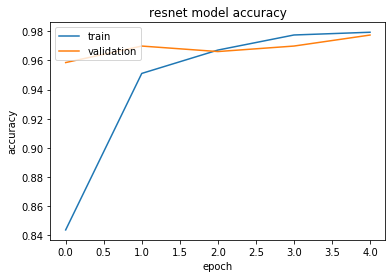

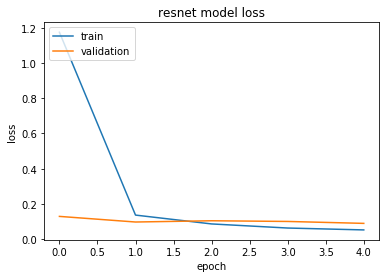

In [49]:
# PLOT RESNET RESULTS
plt.plot(resnet_train_history.history['accuracy'])
plt.plot(resnet_train_history.history['val_accuracy'])
plt.title('resnet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(resnet_train_history.history['loss'])
plt.plot(resnet_train_history.history['val_loss'])
plt.title('resnet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# PLOT VGG RESULTS
plt.plot(vgg_train_history.history['accuracy'])
plt.plot(vgg_train_history.history['val_accuracy'])
plt.title('vgg model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(vgg_train_history.history['loss'])
plt.plot(vgg_train_history.history['val_loss'])
plt.title('vgg model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [50]:
print("results")
result  = resnet_cell_model.evaluate_generator(test_ds, steps=len(test_ds), verbose=1)

print("%s%.2f  "% ("ResNet Loss     : ", result[0]))
print("%s%.2f%s"% ("ResNet Accuracy : ", result[1]*100, "%"))

result  = vgg_cell_model.evaluate_generator(test_ds, steps=len(test_ds), verbose=1)

print("%s%.2f  "% ("VGG Loss     : ", result[0]))
print("%s%.2f%s"% ("VGG Accuracy : ", result[1]*100, "%"))

results
20/20 [==============================] - 68s 3s/step - loss: 0.3445 - accuracy: 0.8734
Loss     : 0.34  
Accuracy : 87.34%


In [51]:
# resnet
y_pred1 = resnet_cell_model.predict(test_ds)
predicted_categories1 = tf.argmax(y_pred1, axis=1)
true_categories1 = tf.concat([y for x, y in test_ds], axis=0)

In [53]:
# resnet
cm1 = confusion_matrix(true_categories1, predicted_categories1)
cm1

array([[ 73, 161],
       [102, 288]])

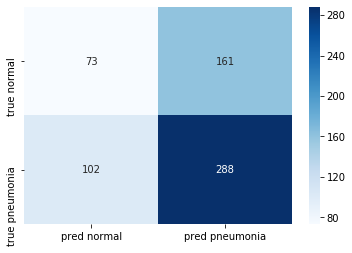

In [54]:
# resnet cm
true_labels=['true normal', 'true pneumonia']
pred_labels=['pred normal', 'pred pneumonia']

cm_plot = sns.heatmap(cm1, annot=True, cmap='Blues', xticklabels=pred_labels, yticklabels=true_labels, fmt='g')

In [198]:
precision = precision_score(true_categories1, predicted_categories1) 
recall = recall_score(true_categories1, predicted_categories1) 
f1 = f1_score(true_categories1, predicted_categories1) 
print("%s%.2f%s"% ("Resnet Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Resnet Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("Resnet F1-Score      : ", f1*100,        "%"))

Precision     : 61.62%
Recall        : 85.64%
F1-Score      : 71.67%


In [199]:
print(classification_report(true_categories1, predicted_categories1, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.32      0.11      0.16       234
   Pneumonia       0.62      0.86      0.72       390

    accuracy                           0.58       624
   macro avg       0.47      0.48      0.44       624
weighted avg       0.50      0.58      0.51       624



In [ ]:
# vgg
y_pred2 = vgg_cell_model.predict(test_ds)
predicted_categories2 = tf.argmax(y_pred2, axis=1)
true_categories2 = tf.concat([y for x, y in test_ds], axis=0)

In [ ]:
# vgg
cm2 = confusion_matrix(true_categories2, predicted_categories2)
cm2

In [ ]:
# vgg cm
cm_plot = sns.heatmap(cm2, annot=True, cmap='Blues', xticklabels=pred_labels, yticklabels=true_labels, fmt='g')

In [ ]:
precision = precision_score(true_categories2, predicted_categories2) 
recall = recall_score(true_categories2, predicted_categories2) 
f1 = f1_score(true_categories2, predicted_categories2) 
print("%s%.2f%s"% ("VGG Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("VGG Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("VGG F1-Score      : ", f1*100,        "%"))